## Case Study 2: Chapter 5 - Windhaven – Integrating Wind Energy and Storage Units

 Authors:   Neeraj Dhanraj Bokde  (www.neerajbokde.in)
            and Carlo Fanara
            
 Affiliation: Renewable & Sustainable Energy Research Center, TII, Abu Dhabi
 
 Corresponding author: neeraj.bokde@tii.ae / neerajdhanraj@gmail.com

 Description:
   This script models the impact of adding wind generation and battery storage
   to a conventionally fossil-based grid using PyPSA. Two networks are compared:
   (1) baseline fossil system, (2) system with wind farm and battery.
   Economic, operational, storage, and emissions results are calculated and visualized.

 Book Reference:
   Bokde, N. D., & Fanara, C. (2025). Decarbonization and Renewable Integration.
   In: The PyPSA Handbook: Integrated Power System Analysis and Renewable 
   Energy Modeling, Chapter 5. 
   Publisher: Elsevier Science
   ISBN: 044326631X, 9780443266317

 Software Dependencies:
   - Python 3.8+
   - pypsa (v0.21+ recommended)
   - numpy, pandas, matplotlib

 License: MIT

 Version: 1.0

 Date: June 2025

In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


### PART 1: Baseline Fossil Fuel-Based Grid

#### Step 1: Initialize the PyPSA network (baseline)

In [2]:
network_old = pypsa.Network()
network_old.set_snapshots(range(24))

#### Step 2: Add a main bus

In [3]:
network_old.add("Bus", "Main Bus")

#### Step 3: Add conventional generators (coal and gas)

In [4]:
network_old.add("Generator", "Coal Plant",
                bus="Main Bus",
                p_nom=150,
                marginal_cost=70,
                carrier="coal",
                p_max_pu=[1.0]*24)
network_old.add("Generator", "Gas Plant",
                bus="Main Bus",
                p_nom=100,
                marginal_cost=50,
                carrier="gas",
                p_max_pu=[1.0]*24)

#### Step 4: Define a dynamic daily load profile

In [5]:
dynamic_load = [100, 120, 140, 160, 180, 200, 220, 200, 180,
                160, 140, 120, 110, 100, 110, 120, 140, 160,
                180, 200, 220, 200, 180, 140]
network_old.add("Load", "City Load", bus="Main Bus", p_set=dynamic_load)

#### Step 5: Optimize baseline network

In [6]:
network_old.optimize(solver_name='glpk')

C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.23s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 48 primals, 120 duals
Objective: 2.17e+05
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-eukj73u1.lp
 --output C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-solve-wkq0xuu2.sol
Reading problem data from 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-eukj73u1.lp'...
120 rows, 48 columns, 144 non-zeros
740 lines were read
GLPK Simplex Optimizer 5.0
120 rows, 48 columns, 144 non-zeros
Preprocessing...
~     0: obj =   2.166000000e+05  infeas =  0.000e+00
OPTIMAL SOLUTION FOUND BY LP PREPROCESSOR
Time used:   0.0 secs
Memory used: 0.1 Mb (89780 bytes)
Writing basic solution to 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-solve-wkq0xuu2.sol'...


('ok', 'optimal')

#### Step 6: Output baseline cost

In [7]:
print("\n====== Windhaven Fossil Baseline ======")
print(f"Total System Cost (OPEX): {network_old.objective:.2f}")


====== Windhaven Fossil Baseline ======
Total System Cost (OPEX): 216600.00


### PART 2: Wind and Storage Integration

#### Step 1: Initialize new network

In [8]:
network_new = pypsa.Network()
network_new.set_snapshots(range(24))

#### Step 2: Replicate bus structure

In [9]:
network_new.add("Bus", "Main Bus")

#### Step 3: Copy fossil generators (ensure robust copy)

In [10]:
for gen in network_old.generators.index:
    gen_data = network_old.generators.loc[gen]
    # If capital_cost column is missing (PyPSA default), set to 0
    capital_cost = gen_data.capital_cost if 'capital_cost' in gen_data.index else 0
    network_new.add("Generator", gen, 
                    bus=gen_data.bus, 
                    p_nom=gen_data.p_nom, 
                    marginal_cost=gen_data.marginal_cost, 
                    capital_cost=capital_cost, 
                    carrier=gen_data.carrier,
                    p_max_pu=[1.0]*24)

#### Step 4: Add dynamic load

In [11]:
network_new.add("Load", "City Load", bus="Main Bus", p_set=dynamic_load)

#### Step 5: Define wind pattern over 24 hours

In [12]:
wind_pattern = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.85,
                0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45,
                0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]

#### Step 6: Add wind generator (100 MW, capital and marginal cost)

In [13]:
network_new.add("Generator", "Wind Farm",
                bus="Main Bus",
                p_nom=100,
                capital_cost=600,
                marginal_cost=10,
                carrier="wind",
                p_max_pu=wind_pattern)

#### Step 7: Add battery storage unit

In [14]:
network_new.add("StorageUnit", "Battery Storage",
                bus="Main Bus",
                p_nom=40,
                capital_cost=200,
                marginal_cost=0.01,
                efficiency_store=0.95,
                efficiency_dispatch=0.95,
                state_of_charge_initial=0.1)

#### Step 8: Optimize new network

In [15]:
network_new.optimize(solver_name='glpk')

C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.71s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 144 primals, 336 duals
Objective: 1.51e+05
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-gwfc4fuk.lp
 --output C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-solve-gr5o3pvy.sol
Reading problem data from 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-gwfc4fuk.lp'...
336 rows, 144 columns, 503 non-zeros
2107 lines were read
GLPK Simplex Optimizer 5.0
336 rows, 144 columns, 503 non-zeros
Preprocessing...
48 rows, 119 columns, 190 non-zeros
Scaling...
 A: min|aij| =  9.500e-01  max|aij| =  1.053e+00  ratio =  1.108e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 48
      0: obj =   2.645926316e+05 inf =   4.901e+02 (14)
     16: obj =   2.547933510e+05 inf =   0.000e+00 (0)
*    93: obj =   1.507860232e+05 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.2 Mb (253484 bytes)
Writing basic solution to 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-

('ok', 'optimal')

#### Step 9: Output results (cost, wind use, storage)

In [16]:
print("\n====== Windhaven with Wind and Storage ======")
print(f"Total System Cost (OPEX + CAPEX): {network_new.objective:.2f}")


====== Windhaven with Wind and Storage ======
Total System Cost (OPEX + CAPEX): 150786.02


### PART 3: Storage Unit Analysis

In [17]:
print("\nBattery Storage Charging (MW):")
print(network_new.storage_units_t.p_store["Battery Storage"].round(2))

print("\nBattery Storage Discharging (MW):")
print(network_new.storage_units_t.p_dispatch["Battery Storage"].round(2))

print("\nBattery State of Charge (MWh):")
print(network_new.storage_units_t.state_of_charge["Battery Storage"].round(2))


Battery Storage Charging (MW):
snapshot
0     12.00
1     20.00
2     10.00
3      0.00
4      0.00
5      0.00
6      0.00
7      0.00
8      0.00
9      0.00
10     0.00
11     0.00
12     0.00
13     0.00
14    17.11
15    25.00
16     0.00
17     0.00
18     0.00
19     0.00
20     0.00
21     0.00
22     0.00
23     0.00
Name: Battery Storage, dtype: float64

Battery Storage Discharging (MW):
snapshot
0      0.0
1      0.0
2      0.0
3      0.0
4     10.0
5     20.0
6      8.0
7      0.0
8      0.0
9      0.0
10     0.0
11     0.0
12     0.0
13     0.0
14     0.0
15     0.0
16     0.0
17    25.0
18    13.0
19     0.0
20     0.0
21     0.0
22     0.0
23     0.0
Name: Battery Storage, dtype: float64

Battery State of Charge (MWh):
snapshot
0     11.50
1     30.50
2     40.00
3     40.00
4     29.47
5      8.42
6      0.00
7      0.00
8      0.00
9      0.00
10     0.00
11     0.00
12     0.00
13     0.00
14    16.25
15    40.00
16    40.00
17    13.68
18     0.00
19     0.00
20    

### PART 4: Generation Dispatch Plots

##### Step 1: Organize data for plotting

In [18]:
hours = range(24)
generation = network_new.generators_t.p
storage_charging = network_new.storage_units_t.p_store["Battery Storage"]
storage_discharging = network_new.storage_units_t.p_dispatch["Battery Storage"]
storage_soc = network_new.storage_units_t.state_of_charge["Battery Storage"]

Prepare DataFrames

In [19]:
df_generation = pd.DataFrame(generation, index=hours)
df_generation['Storage Discharge'] = storage_discharging  # Show on bar

df_storage = pd.DataFrame({
    'Charging': storage_charging,
    'Discharging': storage_discharging,
    'SOC': storage_soc
}, index=hours)

#### Step 2: Plot generation and storage operations

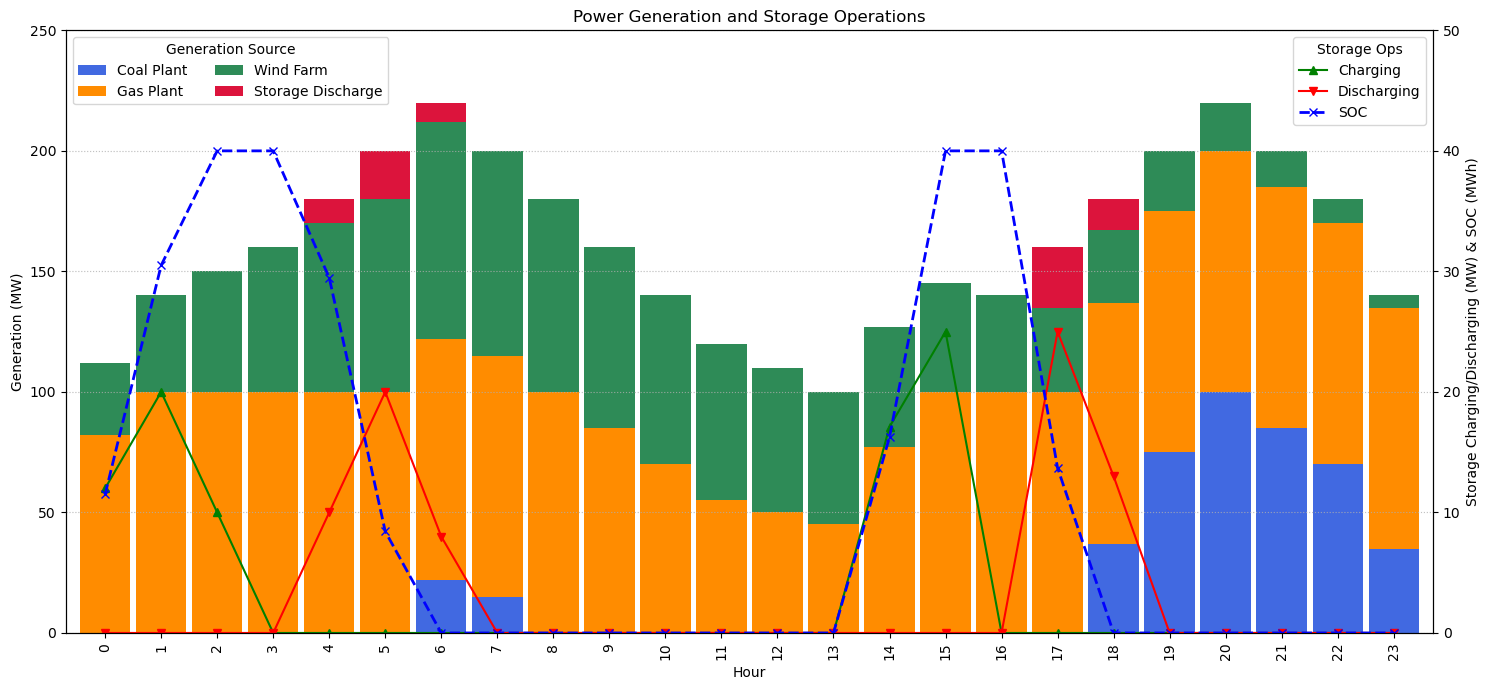

In [20]:
fig, ax1 = plt.subplots(figsize=(15, 7))

# Consistent color codes for generators and storage
color_map = {
    'Coal Plant': 'royalblue',        
    'Gas Plant': 'darkorange',
    'Wind Farm': 'seagreen',          
    'Storage Discharge': 'crimson'    
}

# Plot columns in preferred order
plot_columns = [col for col in ['Coal Plant', 'Gas Plant', 'Wind Farm', 'Storage Discharge'] if col in df_generation.columns]
bar_colors = [color_map[c] for c in plot_columns]

df_generation[plot_columns].plot(
    ax=ax1,
    kind='bar',
    stacked=True,
    width=0.9,
    color=bar_colors
)

ax1.set_title("Power Generation and Storage Operations")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Generation (MW)")
ax1.set_xticks(range(24))
ax1.legend(title="Generation Source", loc='upper left', ncols=2)
ax1.set_ylim(0, 250)
ax1.grid(axis='y', linestyle=':', alpha=0.6)

# Step 3: Overlay storage charging, discharging, SOC on secondary y-axis
ax2 = ax1.twinx()

df_storage['Charging'].plot(
    ax=ax2,
    color='green',
    marker='^',
    linestyle='-',
    linewidth=1.5,
    label='Charging'
)
df_storage['Discharging'].plot(
    ax=ax2,
    color='red',
    marker='v',
    linestyle='-',
    linewidth=1.5,
    label='Discharging'
)
df_storage['SOC'].plot(
    ax=ax2,
    color='blue',
    marker='x',
    linestyle='--',
    linewidth=2,
    label='SOC'
)

ax2.set_ylabel("Storage Charging/Discharging (MW) & SOC (MWh)")
ax2.set_ylim(0, 50)
ax2.legend(title="Storage Ops", loc='upper right', ncols=1)
ax2.grid(axis='y', linestyle=':', alpha=0.4)

plt.tight_layout()
plt.show()

### PART 5: Cost and Emissions Analysis

#### Step 1: Compute average energy cost

In [21]:
old_total_load = sum(network_old.loads_t.p_set["City Load"])
new_total_load = sum(network_new.loads_t.p_set["City Load"])
old_avg_cost = network_old.objective / old_total_load
new_avg_cost = network_new.objective / new_total_load

print("\n--- Energy Cost Comparison ---")
print(f"Average Energy Cost Before (Fossil): {old_avg_cost:.2f}")
print(f"Average Energy Cost After (Wind+Storage): {new_avg_cost:.2f}")


--- Energy Cost Comparison ---
Average Energy Cost Before (Fossil): 57.30
Average Energy Cost After (Wind+Storage): 39.89


#### Step 2: Assign emission factors and calculate total emissions

In [22]:
emission_factors = {
    "Coal Plant": 0.9,    # tons CO2/MWh
    "Gas Plant": 0.4,
    "Wind Farm": 0
}

def assign_emissions(network, efactors):
    for gen, ef in efactors.items():
        if gen in network.generators.index:
            network.generators.loc[gen, "emission_factor"] = ef

assign_emissions(network_old, emission_factors)
assign_emissions(network_new, emission_factors)

def calculate_total_emissions(network):
    total = 0
    for gen_name, gen_data in network.generators.iterrows():
        generation = network.generators_t.p[gen_name]
        ef = gen_data.get("emission_factor", 0)
        total += sum(generation * ef)
    return total

old_emissions = calculate_total_emissions(network_old)
new_emissions = calculate_total_emissions(network_new)

print("\n--- Emissions Comparison ---")
print(f"Total Emissions Before Integration: {old_emissions:.1f} tons CO2")
print(f"Total Emissions After Integration: {new_emissions:.1f} tons CO2")


--- Emissions Comparison ---
Total Emissions Before Integration: 2202.0 tons CO2
Total Emissions After Integration: 1260.7 tons CO2


#### End of Windhaven Case Study Script